In [1]:
import polars as pl
import pandas as pd
from tqdm import tqdm
import os
import json
import numpy as np
from catboost import CatBoostClassifier, CatBoostRanker, Pool, sum_models
from sklearn.utils import resample
from polimi.utils._inference import _inference
from ebrec.evaluation.metrics_protocols import *
from ebrec.utils._behaviors import sampling_strategy_wu2019
from polimi.utils._polars import reduce_polars_df_memory_size
from polimi.test.level_2_ensemble.build_model_predictions import require_subsampled_set, train_predict_model
from fastauc.fastauc.fast_auc import CppAuc
import os
import logging
from lightgbm import LGBMClassifier, LGBMRanker
from datetime import datetime
import argparse
import pandas as pd
import joblib
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing_extensions import List, Tuple, Dict, Type
import optuna
import polars as pl
from catboost import CatBoostClassifier, CatBoostRanker
from xgboost import XGBClassifier, XGBRanker
from polimi.utils._tuning_params import get_models_params
import gc
from polars import testing


In [2]:
drop_me = ['Category_auto_Pct',
           'Category_bibliotek_Pct',
           'Category_biler_Pct',
           'Category_dagsorden_Pct',
           'Category_ferie_Pct',
           'Category_forbrug_Pct',
           'Category_haandvaerkeren_Pct',
           'Category_horoskoper_Pct',
           'Category_incoming_Pct',
           'Category_krimi_Pct',
           'Category_musik_Pct',
           'Category_nationen_Pct',
           'Category_nyheder_Pct',
           'Category_om_ekstra_bladet_Pct',
           'Category_opinionen_Pct',
           'Category_penge_Pct',
           'Category_plus_Pct',
           'Category_podcast_Pct',
           'Category_services_Pct',
           'Category_video_Pct',
           'Category_vin_Pct',
           'EVENTPct',
           'Entity_EVENT_Present',
           'Entity_PER_Present',
           'LOCPct',
           'MISCPct',
           'MaxReadTime',
           'MaxScrollPercentage',
           'MedianReadTime',
           'MedianScrollPercentage',
           'MostFrequentCategory',
           'MostFrequentHour',
           'MostFrequentWeekday',
           'NegativePct',
           'NeutralPct',
           'NumArticlesHistory',
           'NumberDifferentCategories',
           'ORGPct',
           'PERPct',
           'PRODPct',
           'PctCategoryMatches',
           'PctNotDefaultArticles',
           'PctStrongNegative',
           'PctStrongNeutral',
           'PctStrongPositive',
           'PositivePct',
           'TotalReadTime',
           'age',
           'clicked_count_l_inf_impression',
           'endorsement_20h_articleuser_l_inf_articleuser',
           'endorsement_20h_articleuser_macd',
           'endorsement_10h_leak_macd',
           'entropy_impression_mean_JS',
           'entropy_impression_std_JS',
           'entropy_impression_topics_cosine',
           'entropy_impression_trendiness_score_3d_leak',
           'entropy_impression_trendiness_score_category',
           'gender',
           'is_already_seen_article',
           'is_inside_window_1',
           'kurtosis_impression_article_delay_hours',
           'kurtosis_impression_endorsement_10h',
           'kurtosis_impression_endorsement_10h_leak',
           'kurtosis_impression_inview_count',
           'kurtosis_impression_mean_JS',
           'kurtosis_impression_mean_topic_model_cosine',
           'kurtosis_impression_std_JS',
           'kurtosis_impression_topics_cosine',
           'kurtosis_impression_total_read_time',
           'kurtosis_impression_trendiness_score_3d',
           'kurtosis_impression_trendiness_score_3d_leak',
           'kurtosis_impression_trendiness_score_5d',
           'kurtosis_impression_trendiness_score_category',
           'last_session_duration',
           'last_session_time_hour_diff',
           'lda_0_history_mean',
           'lda_0_history_weighted_mean',
           'lda_1_history_mean',
           'lda_1_history_weighted_mean',
           'lda_2_history_mean',
           'lda_2_history_weighted_mean',
           'lda_3_history_mean',
           'lda_3_history_weighted_mean',
           'lda_4_history_mean',
           'lda_4_history_weighted_mean',
           'max_ner_item_knn_scores',
           'max_ner_svd_scores',
           'max_topic_model_cosine',
           'mean_ner_item_knn_scores',
           'mean_ner_svd_scores',
           'mean_prev_sessions_duration',
           'mean_topic_model_cosine',
           'mean_topic_model_cosine_l_inf_article',
           'mean_topic_model_cosine_l_inf_impression',
           'mean_topic_model_cosine_l_inf_user',
           'mean_topic_model_cosine_minus_median_impression',
           'mean_topic_model_cosine_rank_impression',
           'mean_user_trendiness_score',
           'min_JS',
           'min_topic_model_cosine',
           'num_topics',
           'postcode',
           'sentiment_label_diversity_impression',
           'skew_impression_inview_count',
           'skew_impression_mean_topic_model_cosine',
           'skew_impression_std_JS',
           'skew_impression_topics_cosine',
           'skew_impression_total_pageviews/inviews',
           'skew_impression_trendiness_score_3d',
           'skew_impression_trendiness_score_3d_leak',
           'skew_impression_trendiness_score_5d',
           'skew_impression_trendiness_score_category',
           'std_impression_mean_JS',
           'std_impression_mean_topic_model_cosine',
           'std_impression_std_JS',
           'std_impression_topics_cosine',
           'std_impression_trendiness_score_3d',
           'std_impression_trendiness_score_3d_leak',
           'std_impression_trendiness_score_5d',
           'std_impression_trendiness_score_category',
           'std_topic_model_cosine',
           'topics_cosine_l_inf_user',
           'total_ner_item_knn_scores',
           'total_ner_svd_scores',
           'total_pageviews_minus_median_impression',
           'total_pageviews_rank_impression',
           'total_read_time_l_inf_impression',
           'total_read_time_minus_median_impression',
           'total_read_time_rank_impression',
           'trendiness_score_1d/5d',
           'weighted_mean_topic_model_cosine',
           'window_0_history_length',
           'window_1_history_length',
           'window_2_history_length',
           'window_3_history_length',
           'window_topics_score']

In [3]:
RANKER = False
MODEL_LIST = ['catboost_ranker', 'catboost_classifier', 'dcn', 'GANDALF','mlp', 'wd'] # light_gbm_classifier
original_dataset_path = '/home/ubuntu/dataset/ebnerd_small/train/behaviors.parquet'
HYBRID_WEIGHTS = [0.651223860703235, 0.006964258477371873, 0.009186862873165197, 0.06657633706463335, 0.26585853547326727, 0.00019014540832729132]
# level2_train_df=pl.read_parquet()
# level2_val_df=pl.read_parquet()

behaviors_train = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/train/behaviors.parquet')
history_train = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/train/history.parquet')
articles = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/articles.parquet')

article_features = articles.select(['article_id','total_inviews','total_pageviews'])

user_features = behaviors_train.select(['impression_id','user_id']).join(history_train.with_columns(
                        pl.col('article_id_fixed').list.len().alias('history_len')
                    ).select(['user_id','history_len']), on='user_id').drop('user_id')


In [4]:
def prediction_feature_eng(df, models):
    '''
        Do feature engineering of the predictions
    '''
    df = df.with_columns(
        *[
            (pl.col(f'prediction_{model}')-pl.col(f'prediction_{model}').min().over('impression_id')) / 
            (pl.col(f'prediction_{model}').max().over('impression_id')-pl.col(f'normalized_prediction_{model}').min().over('impression_id'))
            for model in models
        ]
    )
    
    return df

In [5]:
def load_predictions(dir, model_list):
    model_name = model_list[0]
    print(f'Loading Predictions for {model_name}')
    merged_df = reduce_polars_df_memory_size(pl.read_parquet(dir + f'/{model_name}_predictions.parquet'), verbose=0)\
        .sort(by=['impression_id','article'])
    original_shape = merged_df.shape[0]
    for df in range(1, len(model_list)):
        model_name = model_list[df]
        print(f'Loading Predictions for {model_name}')
        model_predictions = reduce_polars_df_memory_size(pl.read_parquet(dir + f'/{model_name}_predictions.parquet'),verbose=0).sort(by=['impression_id','article'])
        testing.assert_frame_equal(merged_df.select(['impression_id','article','target']), 
                                   model_predictions.select(['impression_id','article','target']))
        merged_df = merged_df.with_columns(
            model_predictions[f'prediction_{model_name}'].alias(f'prediction_{model_name}')
        )
        assert original_shape == merged_df.shape[0]
        
    return merged_df

In [6]:
def preprocessing(df, path_features, hybrid_weights):
    # MODEL_LIST = ['catboost_ranker', 'catboost_classifier', 'light_gbm_classifier', 'mlp', 'GANDALF', 'wd', 'dcn']
    for model in MODEL_LIST:
        if model in ['mlp', 'GANDALF', 'wd', 'dcn']:
            df = df.with_columns(
                    pl.col(f'prediction_{model}').list.first()    
                )
    df = df.with_columns(
        *[
            ((pl.col(f'prediction_{model}')-pl.col(f'prediction_{model}').min().over('impression_id')) / 
            (pl.col(f'prediction_{model}').max().over('impression_id')-pl.col(f'prediction_{model}').min().over('impression_id'))).alias(f'normalized_prediction_{model}')
            for model in MODEL_LIST
        ]
        ).with_columns(
            *[((pl.col(f'prediction_{model}')-pl.col(f'prediction_{model}').min().over('article')) / 
            (pl.col(f'prediction_{model}').max().over('article')-pl.col(f'prediction_{model}').min().over('article'))).alias(f'art_norm_prediction_{model}')
            for model in MODEL_LIST]
        ).with_columns(
            *[(hybrid_weights[i] * pl.col(f'normalized_prediction_{MODEL_LIST[i]}')).alias(f'prediction_hybrid_{MODEL_LIST[i]}') for i in range(len(MODEL_LIST))]
        ).with_columns(
                pl.sum_horizontal([f"prediction_hybrid_{model}" for model in MODEL_LIST]).alias('prediction_hybrid')
        ).drop( [f'prediction_hybrid_{model}' for model in MODEL_LIST])

    df = df.with_columns(
            *[pl.col(f'prediction_{model}').mean().over('impression_id').alias(f'mean_prediction_{model}') for model in (MODEL_LIST + ['hybrid'])],
            *[pl.col(f'prediction_{model}').skew().over('impression_id').alias(f'skew_prediction_{model}') for model in (MODEL_LIST + ['hybrid'])],
            *[pl.col(f'prediction_{model}').std().over('impression_id').alias(f'std_prediction_{model}') for model in (MODEL_LIST + ['hybrid'])],
            *[pl.col(f'prediction_{model}').median().over('impression_id').alias(f'median_prediction_{model}') for model in (MODEL_LIST + ['hybrid'])],
            *[pl.col(f'prediction_{model}').rank(method='min', descending=True).over('impression_id').alias(f'rank_prediction_{model}') for model in (MODEL_LIST + ['hybrid'])],
        ).rename({'prediction_hybrid' : 'normalized_prediction_hybrid'}).with_columns(   
            pl.mean_horizontal([f'art_norm_prediction_{model}' for model in MODEL_LIST]).alias('art_norm_horizontal_mean'),
            pl.min_horizontal([f'art_norm_prediction_{model}' for model in MODEL_LIST]).alias('art_norm_horizontal_min'),
            pl.max_horizontal([f'art_norm_prediction_{model}' for model in MODEL_LIST]).alias('art_norm_horizontal_max'), 
            pl.mean_horizontal([f'normalized_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('horizontal_mean'),
            pl.min_horizontal([f'normalized_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('horizontal_min'),
            pl.max_horizontal([f'normalized_prediction_{model}' for model in (MODEL_LIST + ['hybrid']) ]).alias('horizontal_max'),
            pl.mean_horizontal([f'rank_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('avg_rank_pos'),
            pl.min_horizontal([f'rank_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('min_rank_pos'),
            pl.max_horizontal([f'rank_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('max_rank_pos'),
            *[(pl.col(f'prediction_{model}') - pl.col(f'median_prediction_{model}')).alias(f'prediction_{model}_minus_median') for model in MODEL_LIST],
        ).rename({'normalized_prediction_hybrid' : 'prediction_hybrid'}).with_columns(
            pl.col('impression_id').count().over('impression_id').alias('n_articles_impression')
        ).with_columns(
            *[(pl.col(f'rank_prediction_{model}')/pl.col('n_articles_impression')).alias(f'normalized_rank_prediction_{model}') for model in (MODEL_LIST + ['hybrid'])]
        ).with_columns(
            pl.mean_horizontal([f'normalized_rank_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('avg_norm_rank_pos'),
            pl.min_horizontal([f'normalized_rank_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('min_norm_rank_pos'),
            pl.max_horizontal([f'normalized_rank_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('max_norm_rank_pos'),
        )
        
    quantile_95 = df.quantile(quantile=0.95).select('horizontal_mean').item()

    df = df.with_columns(
        pl.col('horizontal_mean').mean().over('article').alias('mean_article_horizontal_mean'),
        pl.col('avg_rank_pos').le(3.5).cast(pl.UInt32).alias('is_avg_top_3'),
        pl.col('avg_rank_pos').le(1.5).cast(pl.UInt32).alias('is_avg_top_1'),
        pl.col('horizontal_mean').gt(quantile_95).cast(pl.UInt32).alias('over_95_qt'),
        *[pl.col(f'rank_prediction_{model}').le(3).cast(pl.UInt32).alias(f'is_top_3_{model}') for model in (MODEL_LIST + ['hybrid'])],
        *[pl.col(f'rank_prediction_{model}').le(1).cast(pl.UInt32).alias(f'is_top_1_{model}') for model in (MODEL_LIST + ['hybrid'])],
    ).with_columns(
        pl.sum_horizontal([f'is_top_3_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('agreement_top3'),
        pl.sum_horizontal([f'is_top_1_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('agreement_top1')
    ).with_columns(
        pl.col('agreement_top3')/pl.col('n_articles_impression').alias('normalized_agreement_top3'),
        pl.col('agreement_top1')/pl.col('n_articles_impression').alias('normalized_agreement_top1')
    ).drop([f'is_top_1_{model}' for model in (MODEL_LIST + ['hybrid'])] + [f'is_top_3_{model}' for model in (MODEL_LIST + ['hybrid'])])

    df = df.drop(columns=['target']).join(pl.read_parquet(path_features).drop(drop_me) #.select(['impression_time', 'impression_id', 'article', 'user_id', 'target'])
                                          ,on = ['impression_id', 'article'], how='left')
    
    df = df.with_columns(
        (pl.col('horizontal_mean') - pl.col('horizontal_mean').rolling_mean_by(window_size='1h' ,by='impression_time').over('article')).alias('roll_mean_1h_horizontal_mean'),
        (pl.col('horizontal_mean') - pl.col('horizontal_mean').rolling_mean_by(window_size='1d' ,by='impression_time').over('article')).alias('roll_mean_1d_horizontal_mean'),
        (pl.col('art_norm_horizontal_mean') - pl.col('art_norm_horizontal_mean').rolling_mean_by(window_size='1h' ,by='impression_time').over('article')).alias('roll_mean_1h_art_morm_horizontal_mean'),
        (pl.col('art_norm_horizontal_mean') - pl.col('art_norm_horizontal_mean').rolling_mean_by(window_size='1d' ,by='impression_time').over('article')).alias('roll_mean_1d_art_morm_horizontal_mean'),
        (pl.col('prediction_hybrid') - pl.col('prediction_hybrid').rolling_mean_by(window_size='1h' ,by='impression_time').over('article')).alias('roll_mean_1h_prediction_hybrid'),
        (pl.col('prediction_hybrid') - pl.col('prediction_hybrid').rolling_mean_by(window_size='1d' ,by='impression_time').over('article')).alias('roll_mean_1d_prediction_hybrid')
    )
    
    df = df.with_columns(
        *[(pl.col(f'prediction_{model}') - pl.col(f'prediction_{model}').rolling_mean_by('impression_time', window_size='1h')).alias(f'prediction_{model}_minus_mean_rolling_1h') for model in (MODEL_LIST + ['hybrid'])],
        *[(pl.col(f'prediction_{model}') - pl.col(f'prediction_{model}').rolling_mean_by('impression_time', window_size='1d')).alias(f'prediction_{model}_minus_mean_rolling_1d') for model in (MODEL_LIST + ['hybrid'])],
        *[(pl.col(f'prediction_{model}') - pl.col(f'prediction_{model}').rolling_mean_by('impression_time', window_size='1h').over('user_id')).alias(f'prediction_{model}_minus_mean_rolling_user_1h') for model in (MODEL_LIST + ['hybrid'])],
        *[(pl.col(f'prediction_{model}') - pl.col(f'prediction_{model}').rolling_mean_by('impression_time', window_size='1d').over('user_id')).alias(f'prediction_{model}_minus_mean_rolling_user_1d') for model in (MODEL_LIST + ['hybrid'])],
        *[(pl.col(f'prediction_{model}') - pl.col(f'prediction_{model}').rolling_mean_by('impression_time', window_size='1h').over('category')).alias(f'prediction_{model}_minus_mean_rolling_category_1h') for model in (MODEL_LIST + ['hybrid'])],
        *[(pl.col(f'prediction_{model}') - pl.col(f'prediction_{model}').rolling_mean_by('impression_time', window_size='1d').over('category')).alias(f'prediction_{model}_minus_mean_rolling_category_1d') for model in (MODEL_LIST + ['hybrid'])],
    )
    
    return df

In [7]:

NORMALIZE_OVER_USER_ID = [
    'kenneth_emb_icm',
    'distilbert_emb_icm',
    'bert_emb_icm',
    'roberta_emb_icm',
    'w_2_vec_emb_icm',
    'emotions_emb_icm',
    'constrastive_emb_icm'
]
NORMALIZE_OVER_ARTICLE = [
    'kenneth_emb_icm',
    'distilbert_emb_icm',
    'bert_emb_icm',
    'roberta_emb_icm',
    'w_2_vec_emb_icm',
    'emotions_emb_icm',
    'constrastive_emb_icm'
]

def build_icm_features(df, path):
    recsys_features = pl.read_parquet(path)
    df = df.join(recsys_features, on=['impression_id', 'article', 'user_id'], how= 'left')
    df = df.with_columns(
        *[(pl.col(c) / pl.col(c).max().over(pl.col('user_id'))).alias(f'{c}_l_inf_user_id')
        for c in NORMALIZE_OVER_USER_ID],
        *[pl.col(c).std().over(pl.col('user_id')).alias(f'std_user_id_{c}')
        for c in NORMALIZE_OVER_USER_ID],
        *[pl.col(c).skew().over(pl.col('user_id')).alias(f'skew_user_id_{c}')
        for c in NORMALIZE_OVER_USER_ID],
        *[pl.col(c).kurtosis().over(pl.col('user_id')).alias(f'kurtosis_user_id_{c}')
        for c in NORMALIZE_OVER_USER_ID],
        *[pl.col(c).entropy().over(pl.col('user_id')).alias(f'entropy_user_id_{c}')
        for c in NORMALIZE_OVER_USER_ID],
        *[(pl.col(c) - pl.col(c).median().over(pl.col('user_id'))).alias(f'{c}_minus_median_user_id')
        for c in NORMALIZE_OVER_USER_ID],
        
        *[(pl.col(c) / pl.col(c).max().over(pl.col('article'))).alias(f'{c}_l_inf_article')
        for c in NORMALIZE_OVER_ARTICLE],
        *[pl.col(c).std().over(pl.col('article')).alias(f'std_article_{c}')
        for c in NORMALIZE_OVER_ARTICLE],
        *[pl.col(c).skew().over(pl.col('article')).alias(f'skew_article_{c}')
        for c in NORMALIZE_OVER_ARTICLE],
        *[pl.col(c).kurtosis().over(pl.col('article')).alias(f'kurtosis_article_{c}')
        for c in NORMALIZE_OVER_ARTICLE],
        *[pl.col(c).entropy().over(pl.col('article')).alias(f'entropy_article_{c}')
        for c in NORMALIZE_OVER_ARTICLE],
        *[(pl.col(c) - pl.col(c).median().over(pl.col('article'))).alias(f'{c}_minus_median_article')
        for c in NORMALIZE_OVER_ARTICLE],
    )
    
    return df

In [8]:
level2_train_df = load_predictions('/home/ubuntu/experiments/hybrid_level2' + '/prediction_level_1_train', MODEL_LIST)

Loading Predictions for catboost_ranker
Loading Predictions for catboost_classifier
Loading Predictions for dcn
Loading Predictions for GANDALF
Loading Predictions for mlp
Loading Predictions for wd


In [9]:
level2_train_df = preprocessing(level2_train_df, '/home/ubuntu/experiments/preprocessing_train_small_new/train_ds.parquet', HYBRID_WEIGHTS)
level2_train_df

/tmp/ipykernel_459329/1007067284.py:68: DeprecationWarning: named `columns` param is deprecated; use positional `*args` instead.
  df = df.drop(columns=['target']).join(pl.read_parquet(path_features).drop(drop_me) #.select(['impression_time', 'impression_id', 'article', 'user_id', 'target'])
sys:1: UserWarning: Series is not known to be sorted by `by` column in `rolling_*_by` operation.

To silence this warning, you may want to try:
- sorting your data by your `by` column beforehand;
- setting `.set_sorted()` if you already know your data is sorted;
- passing `warn_if_unsorted=False` if this warning is a false-positive
  (this is known to happen when combining rolling aggregations with `over`);

before passing calling the rolling aggregation function.



impression_id,article,prediction_catboost_ranker,prediction_catboost_classifier,prediction_dcn,prediction_GANDALF,prediction_mlp,prediction_wd,normalized_prediction_catboost_ranker,normalized_prediction_catboost_classifier,normalized_prediction_dcn,normalized_prediction_GANDALF,normalized_prediction_mlp,normalized_prediction_wd,art_norm_prediction_catboost_ranker,art_norm_prediction_catboost_classifier,art_norm_prediction_dcn,art_norm_prediction_GANDALF,art_norm_prediction_mlp,art_norm_prediction_wd,prediction_hybrid,mean_prediction_catboost_ranker,mean_prediction_catboost_classifier,mean_prediction_dcn,mean_prediction_GANDALF,mean_prediction_mlp,mean_prediction_wd,mean_prediction_hybrid,skew_prediction_catboost_ranker,skew_prediction_catboost_classifier,skew_prediction_dcn,skew_prediction_GANDALF,skew_prediction_mlp,skew_prediction_wd,skew_prediction_hybrid,std_prediction_catboost_ranker,std_prediction_catboost_classifier,…,prediction_wd_minus_mean_rolling_1h,prediction_hybrid_minus_mean_rolling_1h,prediction_catboost_ranker_minus_mean_rolling_1d,prediction_catboost_classifier_minus_mean_rolling_1d,prediction_dcn_minus_mean_rolling_1d,prediction_GANDALF_minus_mean_rolling_1d,prediction_mlp_minus_mean_rolling_1d,prediction_wd_minus_mean_rolling_1d,prediction_hybrid_minus_mean_rolling_1d,prediction_catboost_ranker_minus_mean_rolling_user_1h,prediction_catboost_classifier_minus_mean_rolling_user_1h,prediction_dcn_minus_mean_rolling_user_1h,prediction_GANDALF_minus_mean_rolling_user_1h,prediction_mlp_minus_mean_rolling_user_1h,prediction_wd_minus_mean_rolling_user_1h,prediction_hybrid_minus_mean_rolling_user_1h,prediction_catboost_ranker_minus_mean_rolling_user_1d,prediction_catboost_classifier_minus_mean_rolling_user_1d,prediction_dcn_minus_mean_rolling_user_1d,prediction_GANDALF_minus_mean_rolling_user_1d,prediction_mlp_minus_mean_rolling_user_1d,prediction_wd_minus_mean_rolling_user_1d,prediction_hybrid_minus_mean_rolling_user_1d,prediction_catboost_ranker_minus_mean_rolling_category_1h,prediction_catboost_classifier_minus_mean_rolling_category_1h,prediction_dcn_minus_mean_rolling_category_1h,prediction_GANDALF_minus_mean_rolling_category_1h,prediction_mlp_minus_mean_rolling_category_1h,prediction_wd_minus_mean_rolling_category_1h,prediction_hybrid_minus_mean_rolling_category_1h,prediction_catboost_ranker_minus_mean_rolling_category_1d,prediction_catboost_classifier_minus_mean_rolling_category_1d,prediction_dcn_minus_mean_rolling_category_1d,prediction_GANDALF_minus_mean_rolling_category_1d,prediction_mlp_minus_mean_rolling_category_1d,prediction_wd_minus_mean_rolling_category_1d,prediction_hybrid_minus_mean_rolling_category_1d
u32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f64,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
157014,9220931,-0.410128,0.071816,0.083095,0.011657,0.066368,0.041595,0.483657,0.082506,0.099519,0.0,0.059038,0.04091,0.55333,0.081065,0.090465,0.012918,0.081369,0.052557,0.332161,0.166755,0.286931,0.333849,0.335841,0.304157,0.253997,0.540252,-0.961122,0.19052,0.441526,0.389239,0.671541,0.813795,-0.321674,1.251074,0.218732,…,-0.212402,-0.208091,-0.576883,-0.215115,-0.250754,-0.324184,-0.23779,-0.212402,-0.208091,-0.576883,-0.215115,-0.250754,-0.324184,-0.23779,-0.212402,-0.208091,-0.576883,-0.215115,-0.250754,-0.324184,-0.23779,-0.212402,-0.208091,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
157014,9743870,1.746439,0.620796,0.585138,0.815393,0.760625,0.46647,1.0,1.0,0.763631,1.0,1.0,0.618526,0.564762,0.634043,0.604019,0.840982,0.784332,0.477862,0.997756,0.166755,0.286931,0.333849,0.335841,0.304157,0.253997,0.540252,-0.961122,0.19052,0.441526,0.389239,0.671541,0.813795,-0.321674,1.251074,0.218732,…,0.212473,0.457504,1.579684,0.333865,0.251289,0.479552,0.456467,0.212473,0.457504,1.579684,0.333865,0.251

In [10]:
level2_train_df = build_icm_features(level2_train_df, '/mnt/ebs_volume/icm_features/small/train_ds.parquet')
level2_train_df

impression_id,article,prediction_catboost_ranker,prediction_catboost_classifier,prediction_dcn,prediction_GANDALF,prediction_mlp,prediction_wd,normalized_prediction_catboost_ranker,normalized_prediction_catboost_classifier,normalized_prediction_dcn,normalized_prediction_GANDALF,normalized_prediction_mlp,normalized_prediction_wd,art_norm_prediction_catboost_ranker,art_norm_prediction_catboost_classifier,art_norm_prediction_dcn,art_norm_prediction_GANDALF,art_norm_prediction_mlp,art_norm_prediction_wd,prediction_hybrid,mean_prediction_catboost_ranker,mean_prediction_catboost_classifier,mean_prediction_dcn,mean_prediction_GANDALF,mean_prediction_mlp,mean_prediction_wd,mean_prediction_hybrid,skew_prediction_catboost_ranker,skew_prediction_catboost_classifier,skew_prediction_dcn,skew_prediction_GANDALF,skew_prediction_mlp,skew_prediction_wd,skew_prediction_hybrid,std_prediction_catboost_ranker,std_prediction_catboost_classifier,…,emotions_emb_icm_l_inf_article,constrastive_emb_icm_l_inf_article,std_article_kenneth_emb_icm,std_article_distilbert_emb_icm,std_article_bert_emb_icm,std_article_roberta_emb_icm,std_article_w_2_vec_emb_icm,std_article_emotions_emb_icm,std_article_constrastive_emb_icm,skew_article_kenneth_emb_icm,skew_article_distilbert_emb_icm,skew_article_bert_emb_icm,skew_article_roberta_emb_icm,skew_article_w_2_vec_emb_icm,skew_article_emotions_emb_icm,skew_article_constrastive_emb_icm,kurtosis_article_kenneth_emb_icm,kurtosis_article_distilbert_emb_icm,kurtosis_article_bert_emb_icm,kurtosis_article_roberta_emb_icm,kurtosis_article_w_2_vec_emb_icm,kurtosis_article_emotions_emb_icm,kurtosis_article_constrastive_emb_icm,entropy_article_kenneth_emb_icm,entropy_article_distilbert_emb_icm,entropy_article_bert_emb_icm,entropy_article_roberta_emb_icm,entropy_article_w_2_vec_emb_icm,entropy_article_emotions_emb_icm,entropy_article_constrastive_emb_icm,kenneth_emb_icm_minus_median_article,distilbert_emb_icm_minus_median_article,bert_emb_icm_minus_median_article,roberta_emb_icm_minus_median_article,w_2_vec_emb_icm_minus_median_article,emotions_emb_icm_minus_median_article,constrastive_emb_icm_minus_median_article
u32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f64,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
157014,9220931,-0.410128,0.071816,0.083095,0.011657,0.066368,0.041595,0.483657,0.082506,0.099519,0.0,0.059038,0.04091,0.55333,0.081065,0.090465,0.012918,0.081369,0.052557,0.332161,0.166755,0.286931,0.333849,0.335841,0.304157,0.253997,0.540252,-0.961122,0.19052,0.441526,0.389239,0.671541,0.813795,-0.321674,1.251074,0.218732,…,0.088236,0.0,0.00127,5.873093,0.025157,1.669889,0.002895,0.015937,0.001395,3.440812,0.872929,1.051743,6.414873,6.442941,0.805915,12.086261,25.586624,0.531735,1.40609,83.701984,70.570758,0.242988,230.95087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000774,-4.728957,-0.024238,0.0,0.0,-0.009308,0.0
157014,9743870,1.746439,0.620796,0.585138,0.815393,0.760625,0.46647,1.0,1.0,0.763631,1.0,1.0,0.618526,0.564762,0.634043,0.604019,0.840982,0.784332,0.477862,0.997756,0.166755,0.286931,0.333849,0.335841,0.304157,0.253997,0.540252,-0.961122,0.19052,0.441526,0.389239,0.671541,0.813795,-0.321674,1.251074,0.218732,…,0.047619,0.053852,0.002,6.624968,0.049054,3.799606,0.004757,0.012086,0.003178,1.26381,1.156108,1.164172,1.45477,1.495991,1.237313,1.686302,1.816806,1.584308,1.657417,2.765258,2.348628,2.250028,3.935848,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000179,-2.890517,-0.036356,0.923665,0.000002,-0.006648,-0.000073
157014,9769605,-2.430177,0.022449,0.007862,0.011982,0.022809,0.011504,0.0,0.0,0.0,0.000405,0.0,0.0,0.251159,0.019826,0.007993,0.011701,0.022829,0.011288,0.000027,0.166755,0.286931,0.333849,0.335841,0.304157,0.253997,0.540252,-0.961122,0.19052,0.441526,0.389239,0.671541,0.813795,-0.321674,1.251074,0.218732,…,0.080646,0.0,0.002868,4

In [11]:
with open(os.path.join('/home/ubuntu/experiments/preprocessing_train_small_new', 'data_info.json')) as data_info_file:
        data_info = json.load(data_info_file)

categorical_columns = []
for col in data_info['categorical_columns']:
        if col in level2_train_df.columns:
                categorical_columns.append(col)

In [12]:
if not RANKER:
    NPRATIO = 2
    starting_dataset =  pl.read_parquet(original_dataset_path).select(['impression_id','user_id','article_ids_inview','article_ids_clicked'])
    starting_dataset = starting_dataset.filter(pl.col('impression_id').is_in(level2_train_df['impression_id']))
    
    behaviors = pl.concat(
        rows.pipe(
            sampling_strategy_wu2019, npratio=NPRATIO, shuffle=False, with_replacement=True, seed=123
        ).explode('article_ids_inview').drop(columns =['article_ids_clicked']).rename({'article_ids_inview' : 'article'})\
        .with_columns(pl.col('user_id').cast(pl.UInt32),
                      pl.col('article').cast(pl.Int32))\
        
         for rows in tqdm(starting_dataset.iter_slices(1000), total=starting_dataset.shape[0] // 1000)
    ).drop('user_id')
    level2_train_df = behaviors.join(level2_train_df, on = ['impression_id','article'], how = 'left')

  0%|          | 0/98 [00:00<?, ?it/s]/tmp/ipykernel_459329/2316405466.py:7: DeprecationWarning: named `columns` param is deprecated; use positional `*args` instead.
  rows.pipe(
99it [00:02, 43.58it/s]                        


In [13]:
level2_train_df = reduce_polars_df_memory_size(level2_train_df)

categorical_columns = categorical_columns + ['is_avg_top_3', 'is_avg_top_1', 'over_95_qt']
if RANKER:
        level2_train_df = level2_train_df.sort(by='impression_id')
        groups = level2_train_df.select('impression_id').to_numpy().flatten()
        
if 'postcode' in level2_train_df.columns:
        level2_train_df = level2_train_df.with_columns(pl.col('postcode').fill_null(5))
if 'article_type' in level2_train_df.columns:
        level2_train_df = level2_train_df.with_columns(pl.col('article_type').fill_null('article_default'))    
if 'impression_time' in level2_train_df.columns:
        level2_train_df = level2_train_df.drop(columns = ['impression_time'])    
                   
level2_train_df = level2_train_df.to_pandas()
level2_train_df[categorical_columns] = level2_train_df[categorical_columns].astype('category')

group_ids = level2_train_df['impression_id'].to_frame()
if 'user_id' in level2_train_df.columns:
        level2_train_df = level2_train_df.drop(columns = ['user_id'])
level2_train_df = level2_train_df.drop(columns=['impression_id', 'article'])
    
X_train = level2_train_df.drop(columns=['target'])
y_train = level2_train_df['target']

del level2_train_df
gc.collect()

Memory usage of dataframe is 479.31 MB
Memory usage after optimization is: 408.18 MB
Decreased by 14.8%


/tmp/ipykernel_459329/2990928865.py:13: DeprecationWarning: named `columns` param is deprecated; use positional `*args` instead.
  level2_train_df = level2_train_df.drop(columns = ['impression_time'])


0

In [14]:
if RANKER:
    params = {
        "iterations": 2421,
        "learning_rate": 0.061372161824290145,
        "rsm": 0.681769606695633,
        "reg_lambda": 0.4953354255208565,
        "grow_policy": "SymmetricTree",
        "bootstrap_type": "MVS",
        "subsample": 0.5108219602277233,
        "random_strength": 14.089062269780399,
        "fold_permutation_block": 39,
        "border_count": 34,
        "sampling_frequency": "PerTreeLevel",
        "score_function": "Cosine",
        "depth": 8,
        "mvs_reg": 0.0015341832942953422
    }
    catboost = CatBoostRanker(**params) #, cat_features=categorical_columns) #, cat_features=data_info['categorical_columns'])
    catboost.fit(X_train, y_train, group_id=group_ids, verbose=50)
else :
    params = {
        "iterations": 2000,
        "subsample": 0.5,
        "rsm": 0.7
    }
    catboost = CatBoostClassifier(**params, random_state=42, cat_features=categorical_columns)  #, cat_features=data_info['categorical_columns'])
    catboost.fit(X_train, y_train, verbose=50)

Learning rate set to 0.062171
0:	learn: 0.6615864	total: 219ms	remaining: 7m 17s
50:	learn: 0.4484847	total: 7.09s	remaining: 4m 31s
100:	learn: 0.4359761	total: 13.7s	remaining: 4m 17s
150:	learn: 0.4290972	total: 19.6s	remaining: 3m 59s
200:	learn: 0.4239435	total: 27.1s	remaining: 4m 2s
250:	learn: 0.4191431	total: 34s	remaining: 3m 56s
300:	learn: 0.4151657	total: 40.5s	remaining: 3m 48s
350:	learn: 0.4116875	total: 46.2s	remaining: 3m 36s
400:	learn: 0.4088739	total: 52.9s	remaining: 3m 31s
450:	learn: 0.4062434	total: 1m	remaining: 3m 27s
500:	learn: 0.4036971	total: 1m 7s	remaining: 3m 20s
550:	learn: 0.4013356	total: 1m 14s	remaining: 3m 15s
600:	learn: 0.3992272	total: 1m 20s	remaining: 3m 6s
650:	learn: 0.3972409	total: 1m 27s	remaining: 3m 1s
700:	learn: 0.3952885	total: 1m 33s	remaining: 2m 53s
750:	learn: 0.3934937	total: 1m 40s	remaining: 2m 46s
800:	learn: 0.3917797	total: 1m 46s	remaining: 2m 38s
850:	learn: 0.3901015	total: 1m 52s	remaining: 2m 32s
900:	learn: 0.388350

In [15]:
from catboost import Pool

if not RANKER:
    train_pool = Pool(X_train, y_train, cat_features=categorical_columns) #, cat_features=data_info['categorical_columns'])
    feature_importances = catboost.get_feature_importance(train_pool)

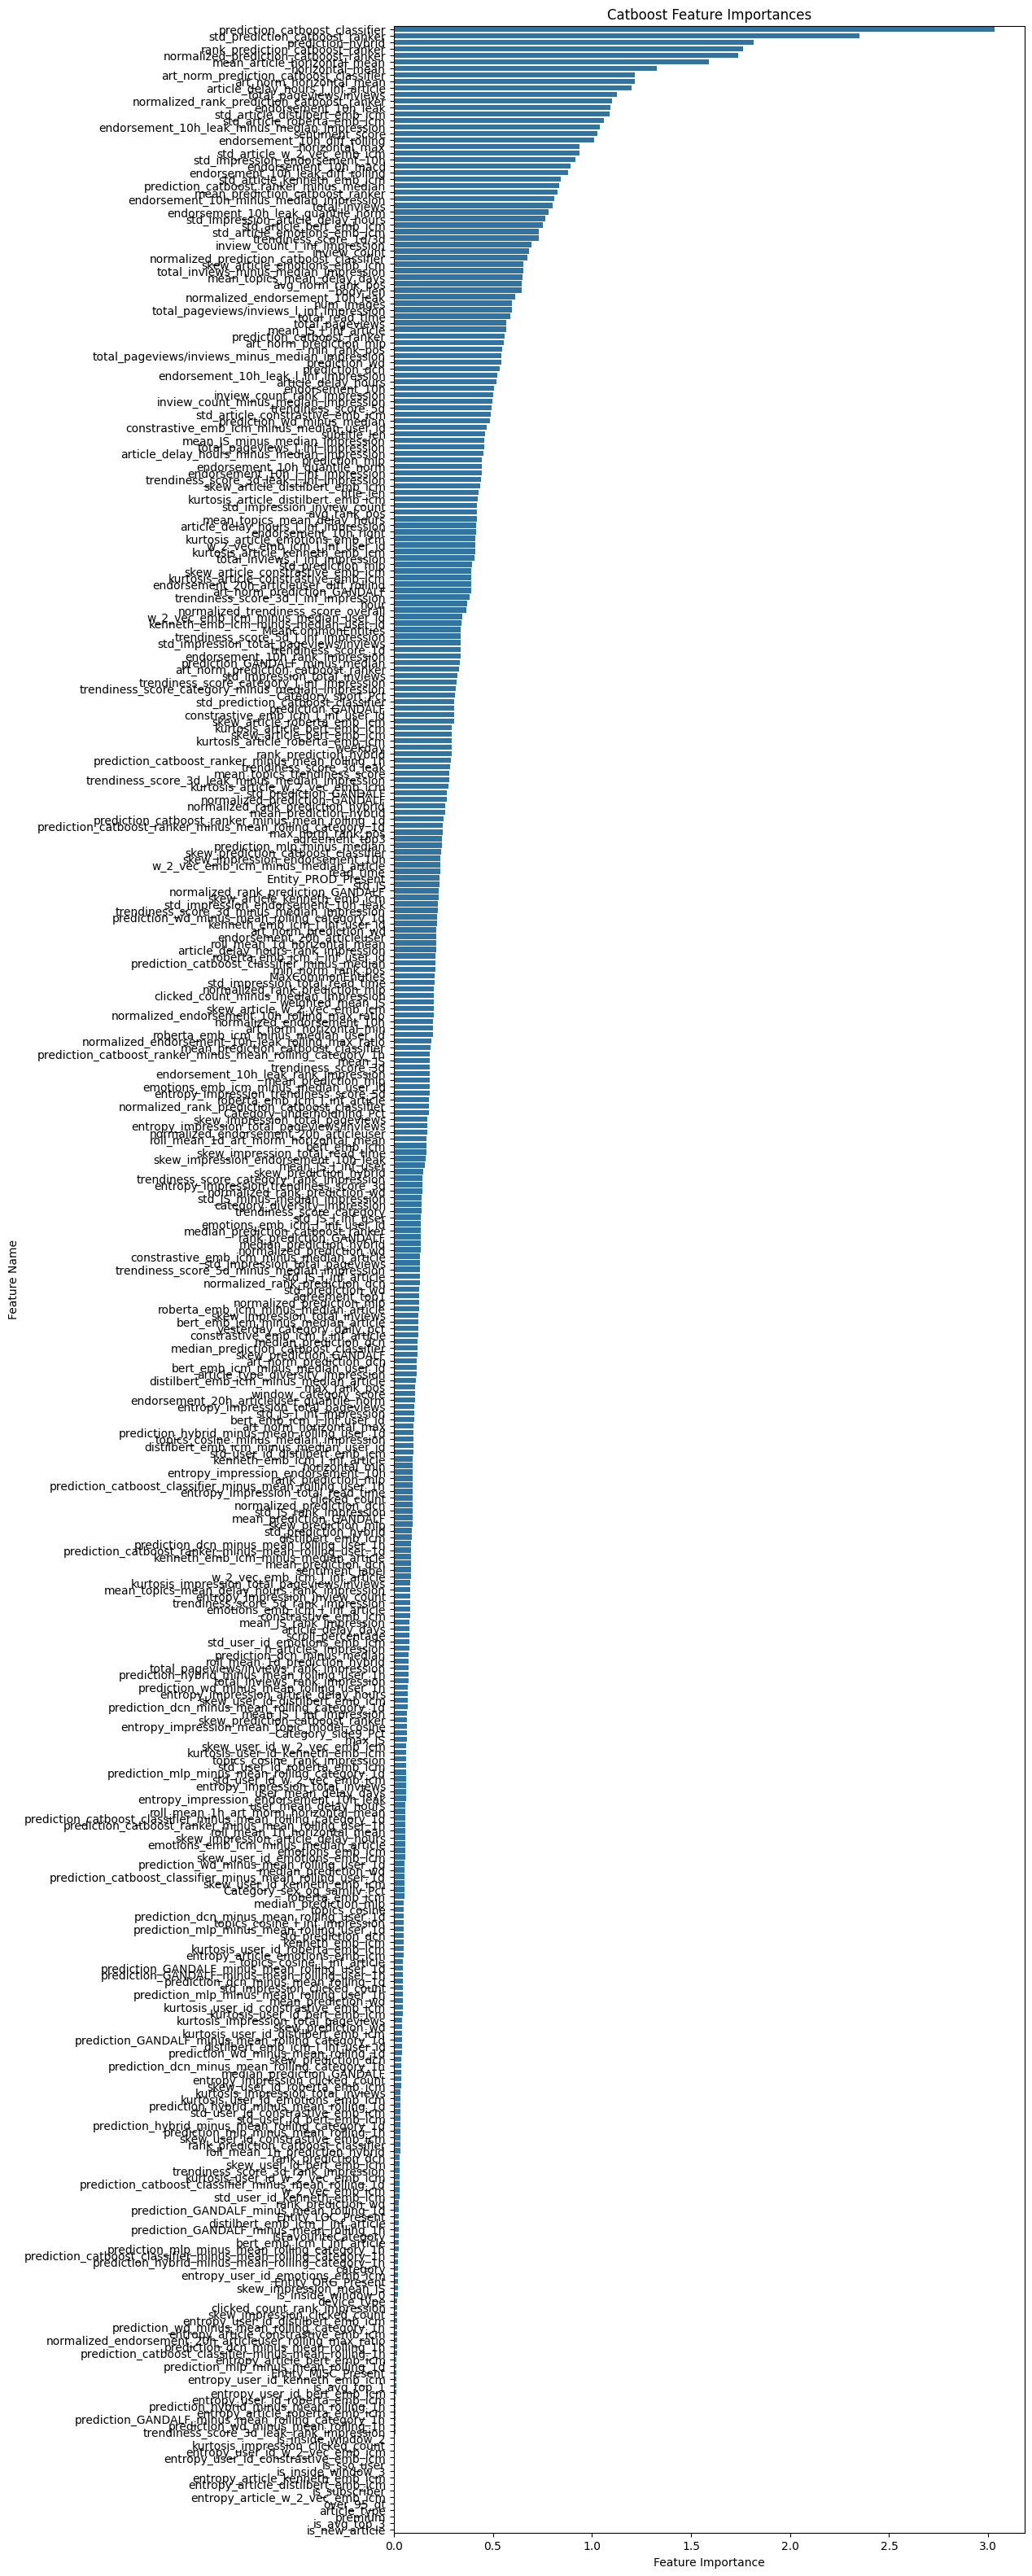

In [16]:
if not RANKER:
    sorted_importances = np.argsort(feature_importances)[::-1]

    plt.figure(figsize=(10, 40))
    sns.barplot(x=feature_importances[sorted_importances], y=np.array(X_train.columns)[sorted_importances])
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Name')
    plt.title('Catboost Feature Importances')

In [17]:
behaviors_train = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/validation/behaviors.parquet')
history_train = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/validation/history.parquet')

article_features = articles.select(['article_id','total_inviews','total_pageviews'])

user_features = behaviors_train.select(['impression_id','user_id']).join(history_train.with_columns(
                        pl.col('article_id_fixed').list.len().alias('history_len')
                    ).select(['user_id','history_len']), on='user_id').drop('user_id')


In [18]:
level2_val_df = load_predictions('/home/ubuntu/experiments/hybrid_level2' + '/prediction_level_1_validation', MODEL_LIST)

Loading Predictions for catboost_ranker


Loading Predictions for catboost_classifier
Loading Predictions for dcn
Loading Predictions for GANDALF
Loading Predictions for mlp
Loading Predictions for wd


In [19]:
level2_val_df = preprocessing(level2_val_df, '/home/ubuntu/experiments/preprocessing_validation_small_new/validation_ds.parquet', HYBRID_WEIGHTS)

/tmp/ipykernel_459329/1007067284.py:68: DeprecationWarning: named `columns` param is deprecated; use positional `*args` instead.
  df = df.drop(columns=['target']).join(pl.read_parquet(path_features).drop(drop_me) #.select(['impression_time', 'impression_id', 'article', 'user_id', 'target'])
sys:1: UserWarning: Series is not known to be sorted by `by` column in `rolling_*_by` operation.

To silence this warning, you may want to try:
- sorting your data by your `by` column beforehand;
- setting `.set_sorted()` if you already know your data is sorted;
- passing `warn_if_unsorted=False` if this warning is a false-positive
  (this is known to happen when combining rolling aggregations with `over`);

before passing calling the rolling aggregation function.



In [20]:
level2_val_df

impression_id,article,prediction_catboost_ranker,prediction_catboost_classifier,prediction_dcn,prediction_GANDALF,prediction_mlp,prediction_wd,normalized_prediction_catboost_ranker,normalized_prediction_catboost_classifier,normalized_prediction_dcn,normalized_prediction_GANDALF,normalized_prediction_mlp,normalized_prediction_wd,art_norm_prediction_catboost_ranker,art_norm_prediction_catboost_classifier,art_norm_prediction_dcn,art_norm_prediction_GANDALF,art_norm_prediction_mlp,art_norm_prediction_wd,prediction_hybrid,mean_prediction_catboost_ranker,mean_prediction_catboost_classifier,mean_prediction_dcn,mean_prediction_GANDALF,mean_prediction_mlp,mean_prediction_wd,mean_prediction_hybrid,skew_prediction_catboost_ranker,skew_prediction_catboost_classifier,skew_prediction_dcn,skew_prediction_GANDALF,skew_prediction_mlp,skew_prediction_wd,skew_prediction_hybrid,std_prediction_catboost_ranker,std_prediction_catboost_classifier,…,prediction_wd_minus_mean_rolling_1h,prediction_hybrid_minus_mean_rolling_1h,prediction_catboost_ranker_minus_mean_rolling_1d,prediction_catboost_classifier_minus_mean_rolling_1d,prediction_dcn_minus_mean_rolling_1d,prediction_GANDALF_minus_mean_rolling_1d,prediction_mlp_minus_mean_rolling_1d,prediction_wd_minus_mean_rolling_1d,prediction_hybrid_minus_mean_rolling_1d,prediction_catboost_ranker_minus_mean_rolling_user_1h,prediction_catboost_classifier_minus_mean_rolling_user_1h,prediction_dcn_minus_mean_rolling_user_1h,prediction_GANDALF_minus_mean_rolling_user_1h,prediction_mlp_minus_mean_rolling_user_1h,prediction_wd_minus_mean_rolling_user_1h,prediction_hybrid_minus_mean_rolling_user_1h,prediction_catboost_ranker_minus_mean_rolling_user_1d,prediction_catboost_classifier_minus_mean_rolling_user_1d,prediction_dcn_minus_mean_rolling_user_1d,prediction_GANDALF_minus_mean_rolling_user_1d,prediction_mlp_minus_mean_rolling_user_1d,prediction_wd_minus_mean_rolling_user_1d,prediction_hybrid_minus_mean_rolling_user_1d,prediction_catboost_ranker_minus_mean_rolling_category_1h,prediction_catboost_classifier_minus_mean_rolling_category_1h,prediction_dcn_minus_mean_rolling_category_1h,prediction_GANDALF_minus_mean_rolling_category_1h,prediction_mlp_minus_mean_rolling_category_1h,prediction_wd_minus_mean_rolling_category_1h,prediction_hybrid_minus_mean_rolling_category_1h,prediction_catboost_ranker_minus_mean_rolling_category_1d,prediction_catboost_classifier_minus_mean_rolling_category_1d,prediction_dcn_minus_mean_rolling_category_1d,prediction_GANDALF_minus_mean_rolling_category_1d,prediction_mlp_minus_mean_rolling_category_1d,prediction_wd_minus_mean_rolling_category_1d,prediction_hybrid_minus_mean_rolling_category_1d
u32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f64,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
96791,9783865,-0.666797,0.082062,0.043175,0.14195,0.060346,0.057008,0.0,0.0,0.0,0.0,0.0,0.0,0.324926,0.088514,0.045872,0.153701,0.067696,0.062322,0.0,0.220082,0.253237,0.350458,0.343151,0.367336,0.337175,0.543405,-0.262577,0.296461,-0.821649,0.419907,-0.58474,-1.18355,-0.353738,0.654151,0.133535,…,-0.280168,-0.543405,-0.886879,-0.171175,-0.307283,-0.201202,-0.30699,-0.280168,-0.543405,-0.886879,-0.171175,-0.307283,-0.201202,-0.30699,-0.280168,-0.543405,-0.886879,-0.171175,-0.307283,-0.201202,-0.30699,-0.280168,-0.543405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96791,9784591,-0.201826,0.24496,0.496269,0.278617,0.492531,0.376784,0.27914,0.44268,0.957946,0.303862,0.834344,0.744446,0.400545,0.24594,0.499679,0.278779,0.498223,0.378448,0.435855,0.220082,0.253237,0.350458,0.343151,0.367336,0.337175,0.543405,-0.262577,0.296461,-0.821649,0.419907,-0.58474,-1.18355,-0.353738,0.654151,0.133535,…,0.039609,-0.10755,-0.421908,-0.008276,0.145811,-0.064534,0.125195,0.039609,-0.10755,-0.421908,-0.008276,0.145811,

In [21]:
level2_val_df = build_icm_features(level2_val_df, '/mnt/ebs_volume/icm_features/small/validation_ds.parquet')
level2_val_df

impression_id,article,prediction_catboost_ranker,prediction_catboost_classifier,prediction_dcn,prediction_GANDALF,prediction_mlp,prediction_wd,normalized_prediction_catboost_ranker,normalized_prediction_catboost_classifier,normalized_prediction_dcn,normalized_prediction_GANDALF,normalized_prediction_mlp,normalized_prediction_wd,art_norm_prediction_catboost_ranker,art_norm_prediction_catboost_classifier,art_norm_prediction_dcn,art_norm_prediction_GANDALF,art_norm_prediction_mlp,art_norm_prediction_wd,prediction_hybrid,mean_prediction_catboost_ranker,mean_prediction_catboost_classifier,mean_prediction_dcn,mean_prediction_GANDALF,mean_prediction_mlp,mean_prediction_wd,mean_prediction_hybrid,skew_prediction_catboost_ranker,skew_prediction_catboost_classifier,skew_prediction_dcn,skew_prediction_GANDALF,skew_prediction_mlp,skew_prediction_wd,skew_prediction_hybrid,std_prediction_catboost_ranker,std_prediction_catboost_classifier,…,emotions_emb_icm_l_inf_article,constrastive_emb_icm_l_inf_article,std_article_kenneth_emb_icm,std_article_distilbert_emb_icm,std_article_bert_emb_icm,std_article_roberta_emb_icm,std_article_w_2_vec_emb_icm,std_article_emotions_emb_icm,std_article_constrastive_emb_icm,skew_article_kenneth_emb_icm,skew_article_distilbert_emb_icm,skew_article_bert_emb_icm,skew_article_roberta_emb_icm,skew_article_w_2_vec_emb_icm,skew_article_emotions_emb_icm,skew_article_constrastive_emb_icm,kurtosis_article_kenneth_emb_icm,kurtosis_article_distilbert_emb_icm,kurtosis_article_bert_emb_icm,kurtosis_article_roberta_emb_icm,kurtosis_article_w_2_vec_emb_icm,kurtosis_article_emotions_emb_icm,kurtosis_article_constrastive_emb_icm,entropy_article_kenneth_emb_icm,entropy_article_distilbert_emb_icm,entropy_article_bert_emb_icm,entropy_article_roberta_emb_icm,entropy_article_w_2_vec_emb_icm,entropy_article_emotions_emb_icm,entropy_article_constrastive_emb_icm,kenneth_emb_icm_minus_median_article,distilbert_emb_icm_minus_median_article,bert_emb_icm_minus_median_article,roberta_emb_icm_minus_median_article,w_2_vec_emb_icm_minus_median_article,emotions_emb_icm_minus_median_article,constrastive_emb_icm_minus_median_article
u32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f64,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
96791,9783865,-0.666797,0.082062,0.043175,0.14195,0.060346,0.057008,0.0,0.0,0.0,0.0,0.0,0.0,0.324926,0.088514,0.045872,0.153701,0.067696,0.062322,0.0,0.220082,0.253237,0.350458,0.343151,0.367336,0.337175,0.543405,-0.262577,0.296461,-0.821649,0.419907,-0.58474,-1.18355,-0.353738,0.654151,0.133535,…,0.150681,0.0,0.002103,6.779265,0.030801,3.140027,0.006229,0.017181,0.002783,1.272064,1.046977,1.088959,1.297803,1.29522,1.078533,1.461609,1.638777,0.643103,0.767744,1.485673,1.405132,0.826377,2.443438,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000422,-2.730756,-0.024237,-1.846875,-0.003178,-0.00133,-0.001478
96791,9784591,-0.201826,0.24496,0.496269,0.278617,0.492531,0.376784,0.27914,0.44268,0.957946,0.303862,0.834344,0.744446,0.400545,0.24594,0.499679,0.278779,0.498223,0.378448,0.435855,0.220082,0.253237,0.350458,0.343151,0.367336,0.337175,0.543405,-0.262577,0.296461,-0.821649,0.419907,-0.58474,-1.18355,-0.353738,0.654151,0.133535,…,0.10145,0.0,0.005739,7.509755,0.047205,6.185093,0.010945,0.016172,0.004107,1.588415,1.063038,1.128102,1.475852,2.023667,1.084642,2.014237,2.528819,0.664436,0.903211,2.306099,5.010594,0.659787,4.696737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002441,0.977748,-0.021208,-0.00018,-0.001672,-0.003989,-0.001263
96791,9784679,0.490838,0.283759,0.408114,0.406924,0.437615,0.381464,0.694972,0.548115,0.771566,0.589136,0.728329,0.75534,0.451658,0.285161,0.414432,0.407297,0.448214,0.385264,0.696486,0.220082,0.253237,0.350458,0.343151,0.367336,0.337175,0.543405,-0.262577,0.296461,-0.821649,0.419907,-0.58474,-1.18355,-0.353738,0.654151,0.13353

In [22]:
if 'postcode' in level2_val_df.columns:
        level2_val_df = level2_val_df.with_columns(pl.col('postcode').fill_null(5))
if 'article_type' in level2_val_df.columns:
        level2_val_df = level2_val_df.with_columns(pl.col('article_type').fill_null('article_default'))  
if 'impression_time' in level2_val_df.columns:
        level2_val_df = level2_val_df.drop(columns = ['impression_time']) 
        
level2_val_df = level2_val_df.to_pandas()
level2_val_df[categorical_columns] = level2_val_df[categorical_columns].astype('category')

X_val = level2_val_df[X_train.columns]
evaluation_ds = pl.from_pandas(level2_val_df[['impression_id', 'article', 'target']])
    
if RANKER:
    prediction_ds = evaluation_ds.with_columns(pl.Series(catboost.predict(X_val)).alias('prediction'))\
        .group_by('impression_id').agg(pl.col('target'), pl.col('prediction'))
else : 
    prediction_ds = evaluation_ds.with_columns(pl.Series(catboost.predict_proba(X_val)[:, 1]).alias('prediction'))\
        .group_by('impression_id').agg(pl.col('target'), pl.col('prediction'))

/tmp/ipykernel_459329/1757020590.py:6: DeprecationWarning: named `columns` param is deprecated; use positional `*args` instead.
  level2_val_df = level2_val_df.drop(columns = ['impression_time'])


In [23]:
cpp_auc = CppAuc()
result = np.mean(
        [cpp_auc.roc_auc_score(np.array(y_t).astype(bool), np.array(y_s).astype(np.float32)) 
            for y_t, y_s in zip(prediction_ds['target'].to_list(), 
                                prediction_ds['prediction'].to_list())]
    )
print(result)

0.8228120828620006


In [24]:
def optimize_parameters(X_train: pd.DataFrame, y_train: pd.DataFrame, X_val: pd.DataFrame, evaluation_ds: pl.DataFrame, 
                        categorical_features: List[str], group_ids: pd.DataFrame, model_class: Type = CatBoostClassifier, 
                        study_name: str = 'catboost_cls_tuning', n_trials: int = 100, storage: str = None) -> Tuple[Dict, pd.DataFrame]:    
    def objective_function(trial: optuna.Trial):
        params = get_models_params(trial, model_class, categorical_features)
        model = model_class(**params)
        if model_class == CatBoostRanker:
            model.fit(X_train, y_train, group_id=group_ids['impression_id'], verbose=50)
        elif model_class in [XGBRanker, LGBMRanker]:
            model.fit(X_train, y_train, group=group_ids.groupby('impression_id')['impression_id'].count().values)
        elif model_class == LGBMClassifier:
            model.fit(X_train, y_train)
        else:
            model.fit(X_train, y_train, verbose=100)
        if model_class in [CatBoostRanker, XGBRanker, LGBMRanker]:
            prediction_ds = evaluation_ds.with_columns(pl.Series(model.predict(X_val)).alias('prediction')) \
                .group_by('impression_id').agg(pl.col('target'), pl.col('prediction'))
        else:
            prediction_ds = evaluation_ds.with_columns(pl.Series(model.predict_proba(X_val)[:, 1]).alias('prediction')) \
                .group_by('impression_id').agg(pl.col('target'), pl.col('prediction'))
        cpp_auc = CppAuc()
        return np.mean(
            [cpp_auc.roc_auc_score(np.array(y_t).astype(bool), np.array(y_s).astype(np.float32)) 
                for y_t, y_s in zip(prediction_ds['target'].to_list(), 
                                    prediction_ds['prediction'].to_list())]
        )
        
    study = optuna.create_study(direction='maximize', study_name=study_name, storage=storage, load_if_exists=True)
    study.optimize(objective_function, n_trials=n_trials, n_jobs=1)
    return study.best_params, study.trials_dataframe()

In [25]:
# best_params, trials_df = optimize_parameters(X_train=X_train, y_train=y_train, X_val=X_val, evaluation_ds=evaluation_ds,
#                                                  categorical_features=categorical_columns, group_ids=group_ids, model_class=CatBoostClassifier,
#                                                  study_name='test', n_trials=200, storage=None)